<a href="https://colab.research.google.com/github/ApahSaroj/WPI/blob/main/Feature_Sel_and_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin

https://github.com/GeostatsGuy

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np


In [4]:
df = pd.read_excel('/content/drive/MyDrive/DATA/WQC_test.xlsx')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.drop('WQC', inplace=True, axis=1)

pho = df['Phosphate']
pho

for i in range(len(pho)):
    if i>5:
        if np.isnan(pho[i]):
                pho[i] = np.mean([pho[i-1], pho[i-2], pho[i-3], pho[i-4], pho[i-5]])
pho

for i in range(4,-1,-1):
    if np.isnan(pho[i]):
            pho[i] = np.mean([pho[i+1], pho[i+2], pho[i+3], pho[i+4], pho[i+5]])
pho

0      0.06211
1      0.00960
2      0.01280
3      0.01536
4      0.01000
        ...   
482    0.01500
483    0.03300
484    0.16300
485    0.21900
486    0.07000
Name: Phosphate, Length: 487, dtype: float64

In [5]:
df.isnull().sum()

pH            0
DO            0
TDS           0
Alkalinity    0
EC            0
Na            0
Ca            0
Mg            0
K             0
F             0
Cl            0
Nitrate       0
Sulphate      0
Phosphate     0
WPI           0
dtype: int64

In [6]:
df

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WPI
0,8.14,8.7,84.0,52.0,147.8,4.48,44.0,20.0,1.17,0.285,7.80,0.758000,6.534660,0.06211,0.249528
1,7.70,8.8,110.0,76.0,188.0,8.61,44.0,36.0,3.46,0.401,14.80,0.196062,8.138620,0.00960,0.216400
2,7.60,7.5,75.0,44.0,128.0,8.11,28.0,20.0,2.80,0.379,14.80,0.298875,3.855625,0.01280,0.183814
3,8.20,9.1,76.0,56.0,127.0,6.30,44.0,18.0,1.65,0.396,9.60,0.299590,2.238750,0.01536,0.219282
4,7.31,7.3,84.0,52.0,140.0,5.50,28.0,20.0,1.61,0.265,8.30,0.106000,5.600000,0.01000,0.165831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,7.60,5.6,224.0,8.0,370.0,16.14,92.0,24.0,7.60,2.270,23.04,1.352000,104.480000,0.01500,0.419630
483,7.30,5.6,266.0,96.0,434.0,20.56,96.0,32.0,9.89,1.550,30.86,7.074000,61.068000,0.03300,0.432996
484,5.10,5.8,290.0,12.0,487.0,37.35,60.0,44.0,14.80,0.159,60.13,9.256000,89.910000,0.16300,0.326811
485,7.40,6.4,230.0,72.0,385.0,20.06,70.0,42.0,10.35,1.360,32.92,7.110435,48.500000,0.21900,0.509970


In [7]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model

In [8]:
import scipy.stats as st                                    # statistical methods
from sklearn.metrics import mean_squared_error, r2_score    # specific measures to check our models
from sklearn.linear_model import Ridge                      # ridge regression implemented in scikit learn
from sklearn.linear_model import Lasso                      # the lasso implemented in scikit learn
from sklearn.model_selection import cross_val_score         # multi-processor K-fold crossvalidation
from sklearn.model_selection import train_test_split      # train and test split
from sklearn.preprocessing import StandardScaler            # standardize the features
from sklearn import metrics                                 # measures to check our models
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error            # specific measures to check our models

In [9]:
def partial_corr(C):   #This uses the linear regression approach to compute the partial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [10]:
def partial_corr(C):

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [11]:
df.head(n=6) 

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WPI
0,8.14,8.7,84.0,52.0,147.8,4.48,44.0,20.0,1.17,0.285,7.80,0.758000,6.534660,0.06211,0.249528
1,7.70,8.8,110.0,76.0,188.0,8.61,44.0,36.0,3.46,0.401,14.80,0.196062,8.138620,0.00960,0.216400
2,7.60,7.5,75.0,44.0,128.0,8.11,28.0,20.0,2.80,0.379,14.80,0.298875,3.855625,0.01280,0.183814
3,8.20,9.1,76.0,56.0,127.0,6.30,44.0,18.0,1.65,0.396,9.60,0.299590,2.238750,0.01536,0.219282
4,7.31,7.3,84.0,52.0,140.0,5.50,28.0,20.0,1.61,0.265,8.30,0.106000,5.600000,0.01000,0.165831
5,8.40,7.4,103.0,52.0,168.0,5.88,40.0,24.0,3.04,0.319,8.29,0.506000,12.810000,0.10600,0.308627


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pH,487.0,7.809275,0.411216,5.100000,7.560000,7.860000,8.100000,8.570000
DO,487.0,7.441561,1.107170,4.200000,6.700000,7.400000,8.100000,13.500000
TDS,487.0,115.752156,47.283961,56.000000,84.000000,102.000000,129.000000,308.000000
Alkalinity,487.0,62.225873,20.068358,8.000000,50.000000,56.000000,72.000000,170.000000
EC,487.0,196.536591,81.088229,98.000000,140.000000,171.000000,219.500000,502.000000
Na,487.0,8.906119,5.719637,2.190000,5.295000,7.100000,10.235000,48.350000
Ca,487.0,43.683778,17.846355,14.000000,32.000000,40.000000,52.000000,146.000000
Mg,487.0,24.361396,10.815360,2.000000,16.000000,22.000000,28.000000,84.000000
K,487.0,3.036222,2.304195,0.500000,1.735000,2.410000,3.400000,18.020000
F,487.0,0.511795,0.494124,0.059000,0.249000,0.312000,0.468000,3.060000


In [13]:
phmin = 5.1; phmax = 8.57; phname = 'pH'; phtitle = 'pH' # user specified min and max values, and labels for plotting
domin = 4.2; domax = 13.5; doname = 'DO'; dotitle = 'DO'                
tdsmin = 0; tdsmax = 56.0; tdsname = 'TDS'; tdstitle = 'TDS'
alkmin = 8.0; alkmax = 170.0; alkname = 'Alkalinity'; alktitle = 'Alkalinity'
ecmin = 98.0; ecmax = 502.0; ecname = 'EC'; ectitle = 'EC' 
namin = 2.19; namax = 48.35; naname = 'Na'; natitle = 'Na'
camin = 14.0; camax = 146.0; caname = 'Ca'; catitle = 'Ca'
mgmin = 2; mgmax = 84; mgname = 'Mg'; mgtitle = 'Mg'
kmin = 0.5; kmax = 18.02; kname = 'K'; ktitle = 'K'
fmin = 0.059; fmax = 3.06; fname = 'F'; ftitle = 'F'
clmin = 3.8; clmax = 73.3; clname = 'Cl'; cltitle = 'Cl'
nitmin = 0.003; nitmax = 9.72; nitname = 'Nitrate'; nittitle = 'Nitrate'
sulmin = 0.790; sulmax = 104.48; sulname = 'Sulphate'; sultitle = 'Sulphate'
phomin = 0.0; phomax = 1.79; phoname = 'Phosphate'; photitle = 'Phosphate'
wpimin = 0.10; wpimax = 1.61; wpiname = 'WPI'; wpititle = 'WPI'

In [14]:
pip install geostatspy

     |████████████████████████████████| 61kB 5.8MB/s 


In [15]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


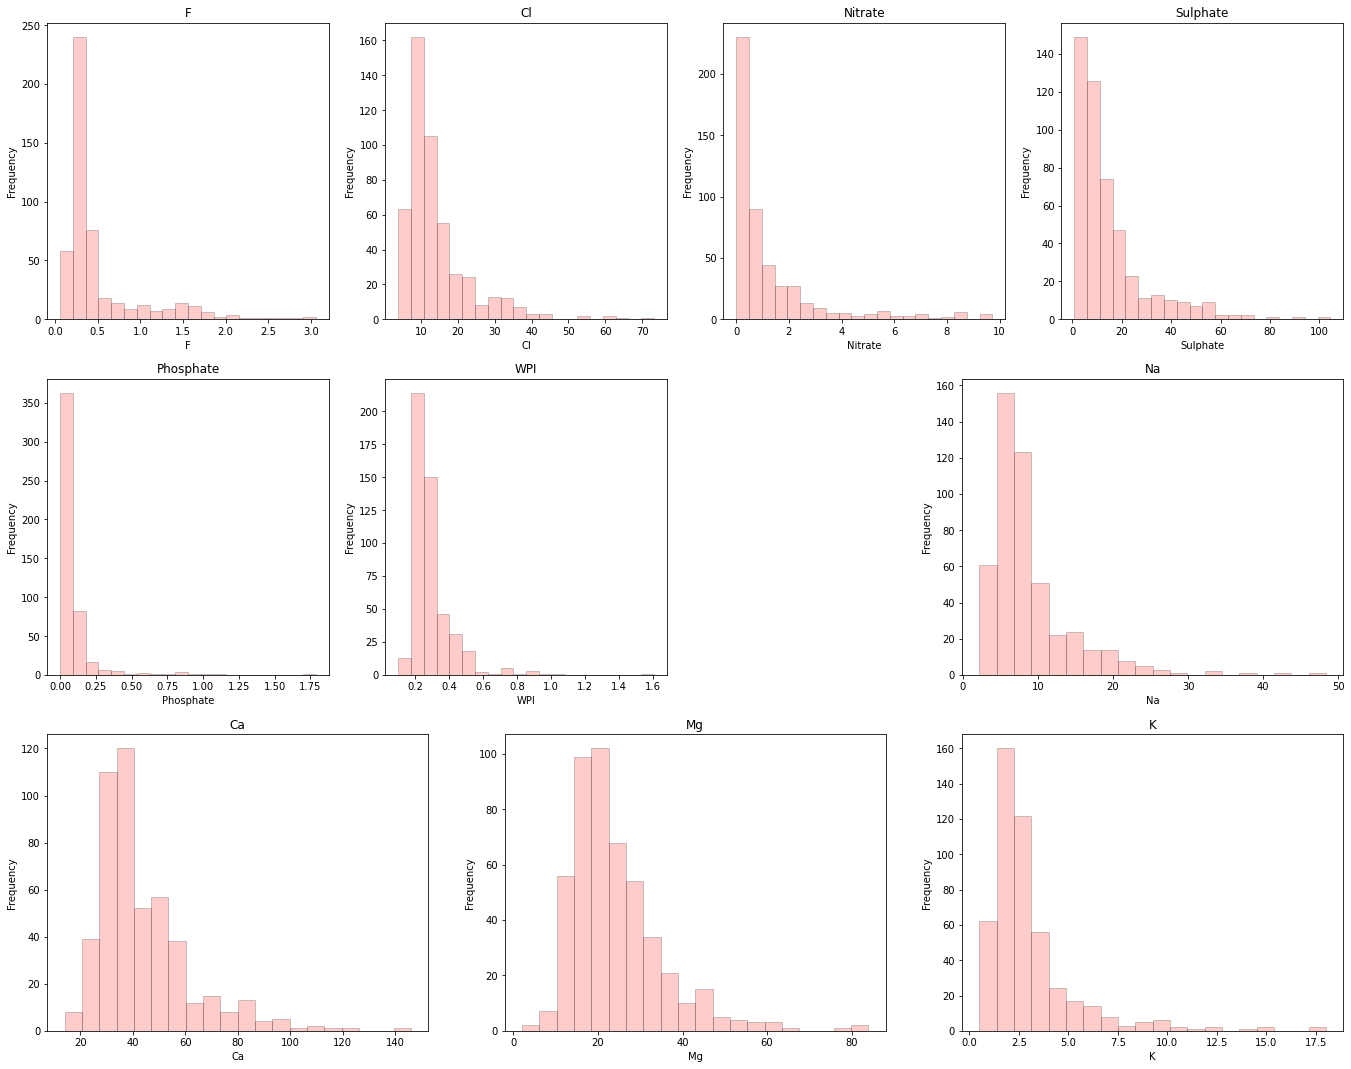

In [16]:
plt.subplot(331)
GSLIB.hist_st(df['pH'].values,phmin,phmax,log=False,cumul = False,bins=20,weights = None,xlabel=phname,title=phtitle)

plt.subplot(332)
GSLIB.hist_st(df['DO'].values,domin,domax,log=False,cumul = False,bins=20,weights = None,xlabel=doname,title=dotitle)

plt.subplot(333)
GSLIB.hist_st(df['TDS'].values,tdsmin,tdsmax,log=False,cumul = False,bins=20,weights = None,xlabel=tdsname,title=tdstitle)

plt.subplot(334)
GSLIB.hist_st(df['Alkalinity'].values,alkmin,alkmax,log=False,cumul = False,bins=20,weights = None,xlabel=alkname,title=alktitle)

plt.subplot(335)
GSLIB.hist_st(df['EC'].values,ecmin,ecmax,log=False,cumul = False,bins=20,weights = None,xlabel=ecname,title=ectitle)

plt.subplot(336)
GSLIB.hist_st(df['Na'].values,namin,namax,log=False,cumul = False,bins=20,weights = None,xlabel=naname,title=natitle)

plt.subplot(337)
GSLIB.hist_st(df['Ca'].values,camin,camax,log=False,cumul = False,bins=20,weights = None,xlabel=caname,title=catitle)

plt.subplot(338)
GSLIB.hist_st(df['Mg'].values,mgmin,mgmax,log=False,cumul = False,bins=20,weights = None,xlabel=mgname,title=mgtitle)

plt.subplot(339)
GSLIB.hist_st(df['K'].values,kmin,kmax,log=False,cumul = False,bins=20,weights = None,xlabel=kname,title=ktitle)

plt.subplot(341)
GSLIB.hist_st(df['F'].values,fmin,fmax,log=False,cumul = False,bins=20,weights = None,xlabel=fname,title=ftitle)

plt.subplot(342)
GSLIB.hist_st(df['Cl'].values,clmin,clmax,log=False,cumul = False,bins=20,weights = None,xlabel=clname,title=cltitle)

plt.subplot(343)
GSLIB.hist_st(df['Nitrate'].values,nitmin,nitmax,log=False,cumul = False,bins=20,weights = None,xlabel=nitname,title=nittitle)

plt.subplot(344)
GSLIB.hist_st(df['Sulphate'].values,sulmin,sulmax,log=False,cumul = False,bins=20,weights = None,xlabel=sulname,title=sultitle)

plt.subplot(345)
GSLIB.hist_st(df['Phosphate'].values,phomin,phomax,log=False,cumul = False,bins=20,weights = None,xlabel=phoname,title=photitle)

plt.subplot(346)
GSLIB.hist_st(df['WPI'].values,wpimin,wpimax,log=False,cumul = False,bins=20,weights = None,xlabel=wpiname,title=wpititle)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins1.tif',dpi=600,bbox_inches="tight")
plt.show()

In [17]:
#sns.pairplot(df,vars=['pH',	'DO',	'TDS',	'Alkalinity',	'EC',	'Na',	'Ca',	'Mg',	'K',	'F',	'Cl',	'Nitrate',	'Sulphate',	'Phosphate',	'WPI'],markers='o')

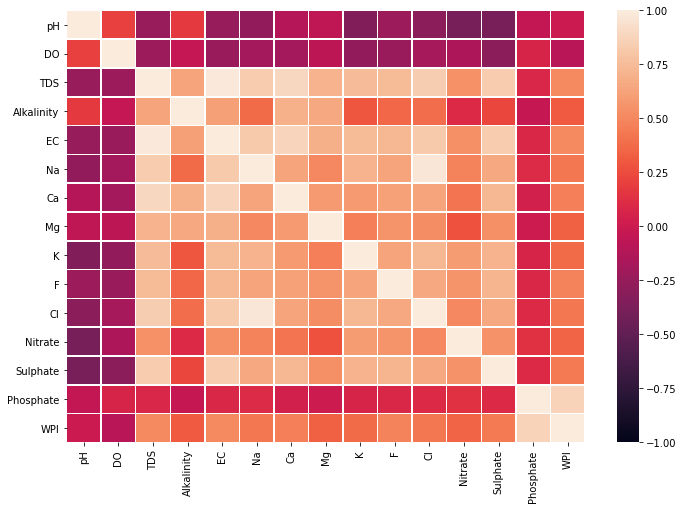

In [18]:
plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(df.iloc[:,0:15].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

In [19]:
covariance = df.iloc[:,0:15].cov().iloc[14,:14]
print(covariance)

pH           -0.000237
DO           -0.013318
TDS           3.189125
Alkalinity    0.817256
EC            5.528586
Na            0.331208
Ca            1.096184
Mg            0.475634
K             0.115371
F             0.031324
Cl            0.530778
Nitrate       0.083722
Sulphate      0.850345
Phosphate     0.018091
Name: WPI, dtype: float64


In [20]:
correlation = df.iloc[:,0:15].corr().iloc[14,:14]
print(correlation)

pH           -0.004345
DO           -0.090860
TDS           0.509463
Alkalinity    0.307611
EC            0.515005
Na            0.437408
Ca            0.463969
Mg            0.332190
K             0.378211
F             0.478850
Cl            0.432062
Nitrate       0.343943
Sulphate      0.438617
Phosphate     0.873668
Name: WPI, dtype: float64


In [21]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,0:15]) # calculate the range correlation coefficient
rank_correlation = rank_correlation[:,14][:14]
rank_correlation_pval = rank_correlation_pval[:,14][:14]
print(rank_correlation)
print(rank_correlation_pval)

[ 0.05875858 -0.33596389  0.64754795  0.44773255  0.65416761  0.52288679
  0.62884878  0.38242921  0.4925354   0.50933988  0.51324995  0.32545405
  0.49635476  0.61592471]
[1.95501275e-01 2.58530009e-14 3.17203517e-59 2.20040457e-25
 8.36425292e-61 1.58743545e-35 5.70326262e-55 2.08293320e-18
 3.99288503e-31 1.65775807e-33 4.42691018e-34 1.76953947e-13
 1.17895435e-31 3.39595655e-52]


In [22]:
partial_correlation = partial_corr(df.iloc[:,0:15]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,14][:14] # extract a single row and remove production with itself
print(partial_correlation)

[ 0.89958842 -0.71246132  0.07343491  0.24063615  0.08821833  0.10840593
  0.5946773   0.0815811   0.03030661  0.84088876 -0.02111773  0.04030432
 -0.03059251  0.99595935]


In [23]:
semipartial_correlation = semipartial_corr(df.iloc[:,0:15]) # calculate the semi-partial correlation coefficients
semipartial_correlation = semipartial_correlation[:,14][:14] # extract a single row and remove production with itself
print(semipartial_correlation)

[ 0.51134669 -0.43016116  0.11170018  0.21016846  0.11670697  0.08966273
  0.29693853  0.14112161  0.07276036  0.54332692  0.06027886  0.05784574
  0.03378767  0.97532622]


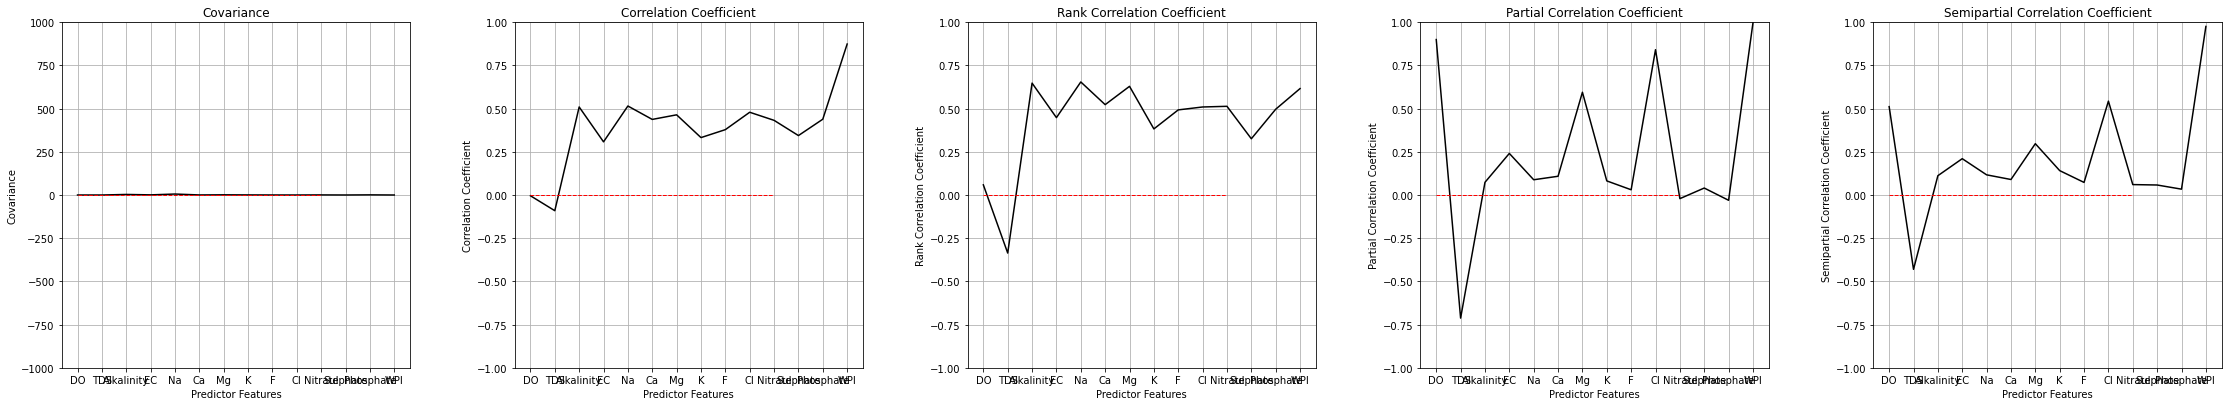

In [24]:
features = df.columns.values[1:][:14]
plt.subplot(151)
plt.plot(features,covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1000,1000)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=5, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

In [25]:
dfS = pd.DataFrame()                      # affine correction of each feature, standardization to a mean of 0 and variance of 1 
dfS['pH'] = df['pH'].values
dfS['DO'] = GSLIB.affine(df['DO'].values,0.0,1.0)
dfS['TDS'] = GSLIB.affine(df['TDS'].values,0.0,1.0)
dfS['Alkalinity'] = GSLIB.affine(df['Alkalinity'].values,0.0,1.0)
dfS['EC'] = GSLIB.affine(df['EC'].values,0.0,1.0)
dfS['Na'] = GSLIB.affine(df['Na'].values,0.0,1.0)
dfS['Ca'] = GSLIB.affine(df['Ca'].values,0.0,1.0)
dfS['Mg'] = GSLIB.affine(df['Mg'].values,0.0,1.0)
dfS['K'] = GSLIB.affine(df['K'].values,0.0,1.0)
dfS['F'] = GSLIB.affine(df['F'].values,0.0,1.0)
dfS['Cl'] = GSLIB.affine(df['Cl'].values,0.0,1.0)
dfS['Nitrate'] = GSLIB.affine(df['Nitrate'].values,0.0,1.0)
dfS['Sulphate'] = GSLIB.affine(df['Sulphate'].values,0.0,1.0)
dfS['Phosphate'] = GSLIB.affine(df['Phosphate'].values,0.0,1.0)
dfS['WPI'] = GSLIB.affine(df['WPI'].values,0.0,1.0)
dfS.head()

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WPI
0,8.14,1.137796,-0.672211,-0.510076,-0.601650,-0.774642,0.017737,-0.403674,-0.810756,-0.459456,-0.687718,-0.287660,-0.564424,-0.174739,-0.332426
1,7.70,1.228210,-0.121776,0.687066,-0.105384,-0.051826,0.017737,1.077225,0.184105,-0.224455,0.067414,-0.593594,-0.454782,-0.510808,-0.582921
2,7.60,0.052837,-0.862746,-0.909123,-0.846079,-0.139334,-0.879726,-0.403674,-0.102624,-0.269024,0.067414,-0.537620,-0.747554,-0.490328,-0.829312
3,8.20,1.499450,-0.841576,-0.310552,-0.858424,-0.456113,0.017737,-0.588786,-0.602226,-0.234584,-0.493541,-0.537231,-0.858078,-0.473944,-0.561127
4,7.31,-0.127990,-0.672211,-0.510076,-0.697940,-0.596125,-0.879726,-0.403674,-0.619604,-0.499973,-0.633780,-0.642627,-0.628314,-0.508248,-0.965287


In [26]:
dfS = pd.DataFrame()                      # Gaussian transform of each feature, standardization to a mean of 0 and variance of 1 
dfS['pH'] = df['pH'].values
dfS['DO'],d1,d2 = geostats.nscore(df,'DO')
dfS['TDS'],d1,d2 = geostats.nscore(df,'TDS')
dfS['Alkalinity'],d1,d2 = geostats.nscore(df,'Alkalinity')
dfS['EC'],d1,d2 = geostats.nscore(df,'EC')
dfS['Na'],d1,d2 = geostats.nscore(df,'Na')
dfS['Ca'],d1,d2 = geostats.nscore(df,'Ca')
dfS['Mg'],d1,d2 = geostats.nscore(df,'Mg')
dfS['K'],d1,d2 = geostats.nscore(df,'K')
dfS['F'],d1,d2 = geostats.nscore(df,'F')
#dfS['PTRATIO'],d1,d2 = geostats.nscore(df,'PTRATIO')
dfS['Cl'],d1,d2 = geostats.nscore(df,'Cl')
dfS['Nitrate'],d1,d2 = geostats.nscore(df,'Nitrate')
dfS['Sulphate'],d1,d2 = geostats.nscore(df,'Sulphate')
dfS['Phosphate'],d1,d2 = geostats.nscore(df,'Phosphate')
dfS['WPI'],d1,d2 = geostats.nscore(df,'WPI')

dfS.head()

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WPI
0,8.14,1.260769,-0.644105,-3.410585e-01,-0.481178,-1.174371,0.379506,-0.061804,-1.411454,-0.239022,-0.855640,0.249628,-0.429786,0.286980,-0.108300
1,7.70,1.357766,0.297724,8.933622e-01,0.281621,0.424148,0.379506,1.260769,0.722112,0.498588,0.575902,-0.826317,-0.155031,-1.397652,-0.833580
2,7.60,0.186368,-1.249454,-9.565211e-01,-1.124549,0.270926,-0.924481,-0.061804,0.346519,0.379506,0.575902,-0.527947,-1.195139,-1.184691,-1.622376
3,8.20,1.567306,-1.164175,-1.490051e-08,-1.216435,-0.270926,0.379506,-0.424148,-0.790633,0.458188,-0.429786,-0.516150,-1.915400,-1.015093,-0.715447
4,7.31,-0.066962,-0.644105,-3.410585e-01,-0.669651,-0.637785,-0.924481,-0.061804,-0.855640,-0.516150,-0.702213,-1.295720,-0.631489,-1.332331,-2.109429


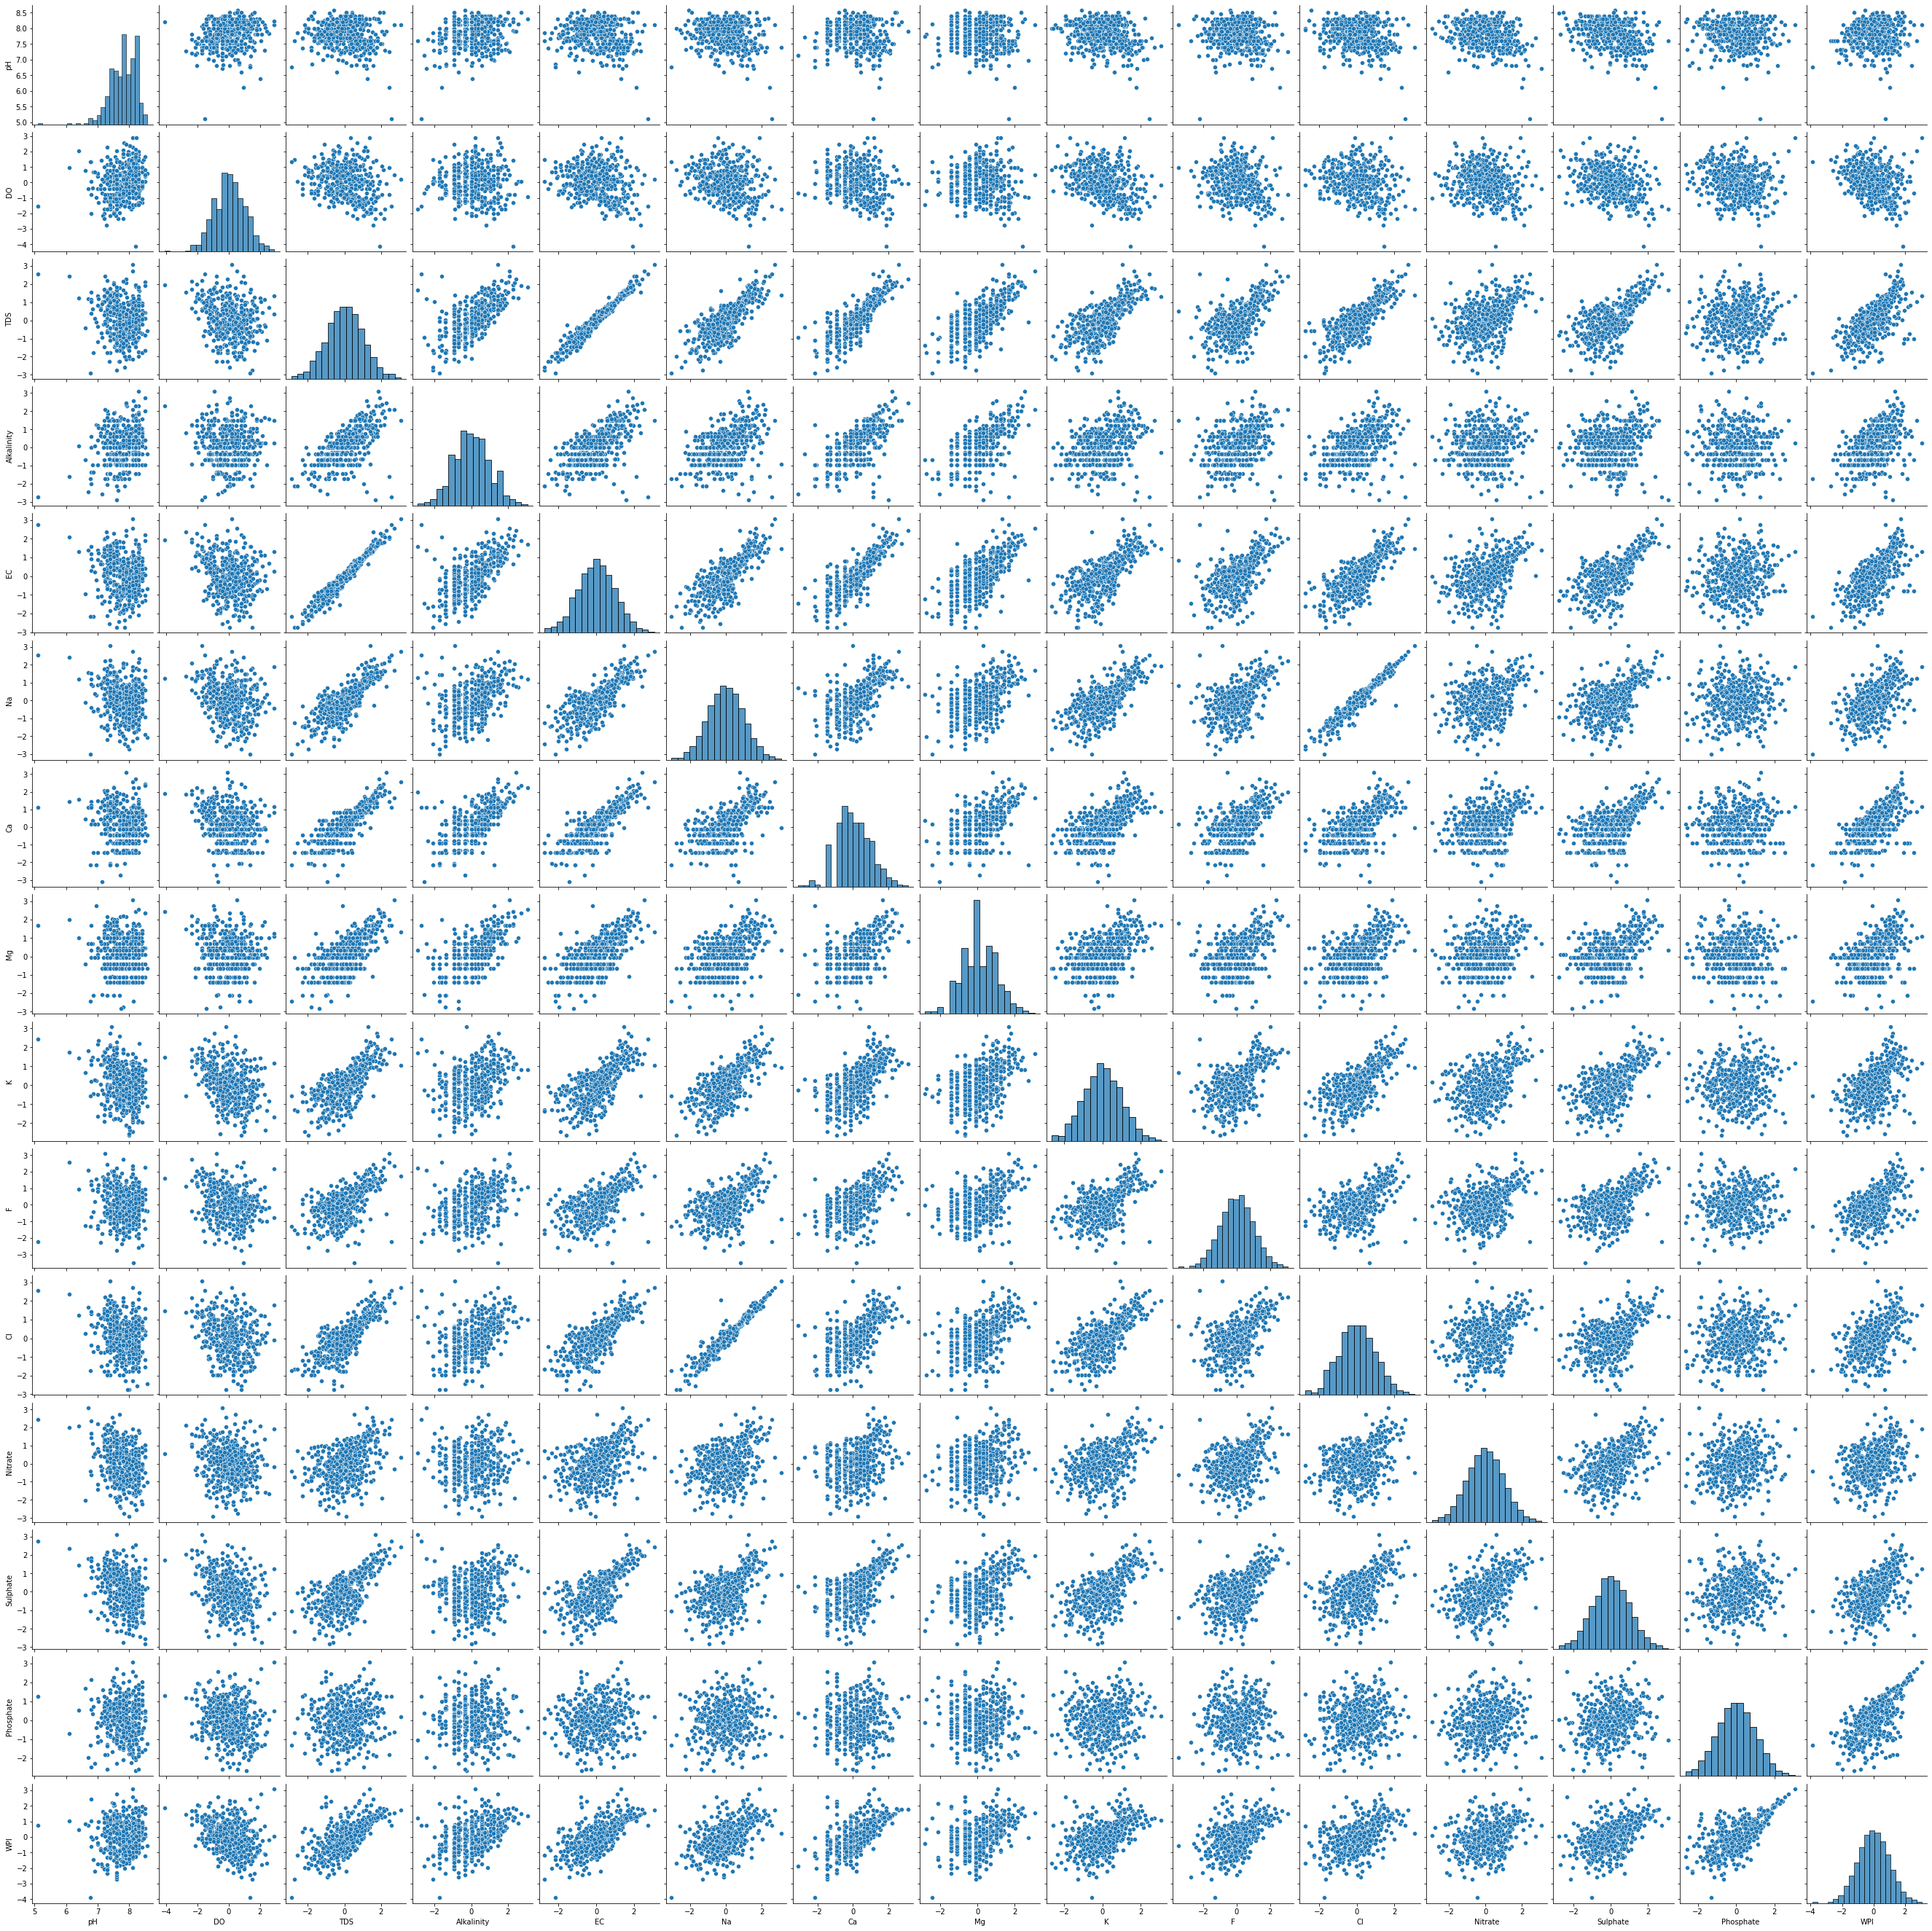

In [27]:
sns.pairplot(dfS,vars=['pH',	'DO',	'TDS',	'Alkalinity',	'EC',	'Na',	'Ca',	'Mg',	'K',	'F',	'Cl',	'Nitrate',	'Sulphate',	'Phosphate',	'WPI'],markers='o')

In [28]:
stand_covariance = dfS.iloc[:,0:15].cov().iloc[14,:14]
stand_correlation = dfS.iloc[:,0:15].corr().iloc[14,:14]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,0:15])
stand_rank_correlation = stand_rank_correlation[:,14][:14]
stand_rank_correlation_pval = stand_rank_correlation_pval[:,14][:14]
stand_partial_correlation = partial_corr(dfS.iloc[:,0:15])
stand_partial_correlation = stand_partial_correlation[:,14][:14]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,0:15])
stand_semipartial_correlation = stand_semipartial_correlation[:,14][:14]

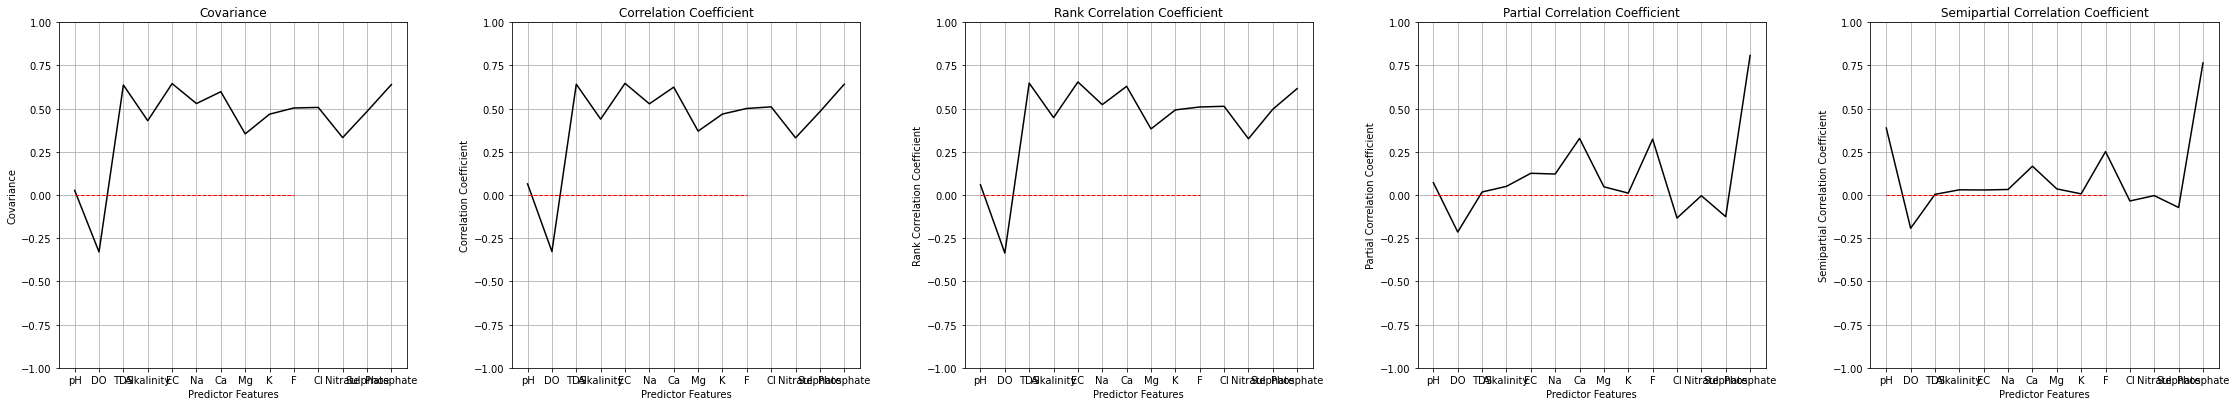

In [29]:
features = df.columns.values[0:][:14]
plt.subplot(151)
plt.plot(features,stand_covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,stand_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,stand_rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,stand_partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,stand_semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=5, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Feature ranking:
1. feature Phosphate = 1.000000
2. feature Ca = 0.907372
3. feature TDS = 0.790794
4. feature EC = 0.777902
5. feature Cl = 0.606562
6. feature Mg = 0.581201
7. feature Na = 0.578073
8. feature K = 0.561541
9. feature F = 0.553882
10. feature Sulphate = 0.511890
11. feature Nitrate = 0.389874
12. feature Alkalinity = 0.363672
13. feature DO = 0.335406
14. feature pH = 0.207628


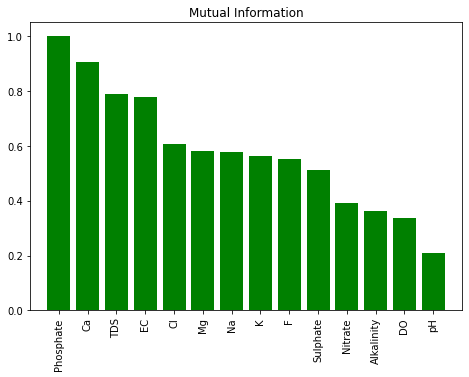

In [30]:
from sklearn.feature_selection import mutual_info_regression

x = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[14]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

From mutual information, we observe that Phosphate, Ca, TDS,EC, Cl have the greatest departure from general independence.

In [31]:
linear_reg = LinearRegression().fit(df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]].values,df.iloc[:,[14]].values)
print('Features: ' + str(df.columns[0:14].values))
b = np.round(linear_reg.coef_,2)[0]
print('B coefficients:' + str(b))

Features: ['pH' 'DO' 'TDS' 'Alkalinity' 'EC' 'Na' 'Ca' 'Mg' 'K' 'F' 'Cl' 'Nitrate'
 'Sulphate' 'Phosphate']
B coefficients:[ 0.05 -0.01  0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.
  0.    0.71]


In [32]:
linear_reg_standardized = LinearRegression().fit(dfS.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]].values,dfS.iloc[:,[14]].values)
print('Features: ' + str(dfS.columns[1:14].values))
beta = np.round(linear_reg_standardized.coef_,2)[0]
print('Beta coefficients:' + str(beta))

Features: ['DO' 'TDS' 'Alkalinity' 'EC' 'Na' 'Ca' 'Mg' 'K' 'F' 'Cl' 'Nitrate'
 'Sulphate' 'Phosphate']
Beta coefficients:[ 0.54 -0.12  0.07 -0.03  0.22  0.12  0.27  0.03  0.03  0.16 -0.1   0.03
 -0.04  0.6 ]


We see phosphate, DO, Mg, Na have the great weight in the estimate of WPI

Feature ranking:
1. feature 13 (0.415814)
2. feature 2 (0.254455)
3. feature 4 (0.101877)
4. feature 6 (0.082871)
5. feature 0 (0.046088)
6. feature 9 (0.044776)
7. feature 1 (0.012275)
8. feature 3 (0.008307)
9. feature 5 (0.006923)
10. feature 8 (0.006661)
11. feature 12 (0.005967)
12. feature 10 (0.005130)
13. feature 11 (0.004696)
14. feature 7 (0.004162)


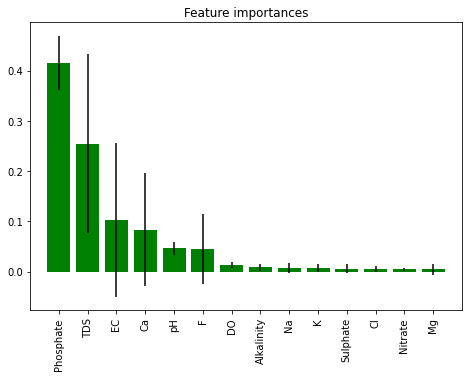

In [33]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')     

x = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[14]]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest = RandomForestRegressor()   # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest.feature_importances_ # extract the expected feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

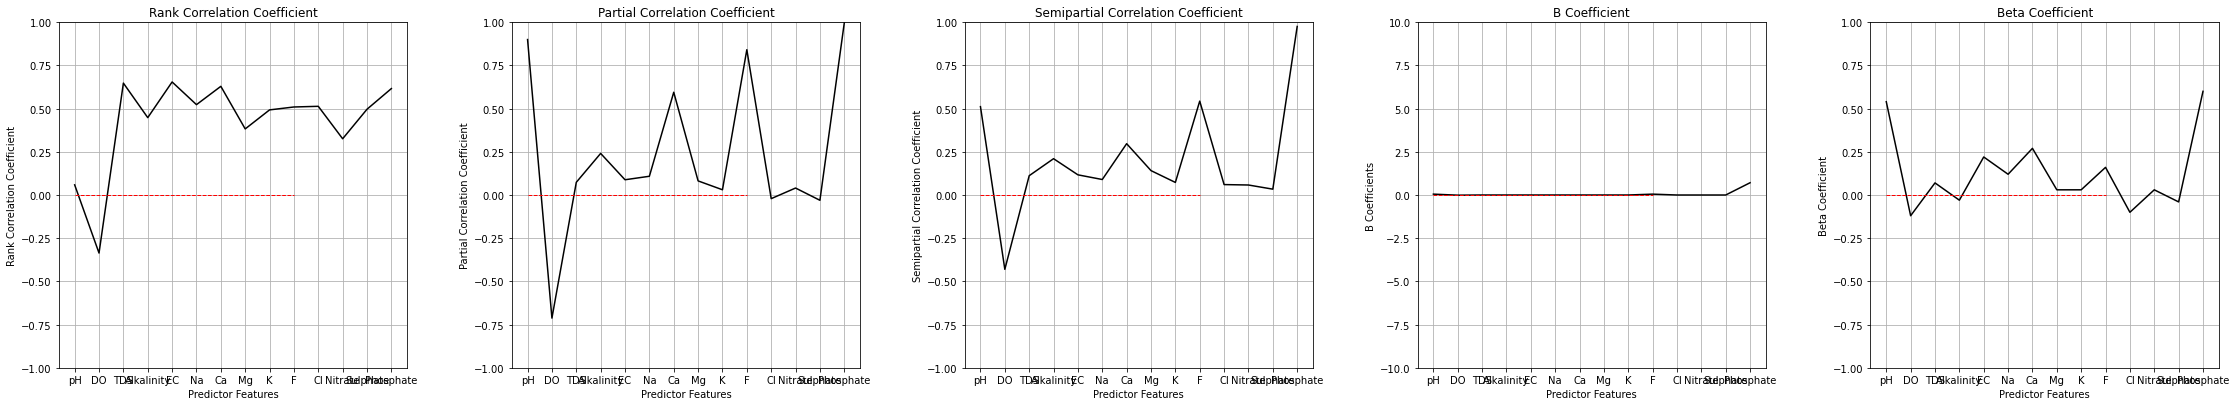

In [34]:
plt.subplot(151)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,b[0:14],color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('B Coefficients')
t = plt.title('B Coefficient')
plt.ylim(-10,10)
plt.grid(True)

plt.subplot(155)
plt.plot(features,beta[0:14],color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Beta Coefficient')
t = plt.title('Beta Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=5, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

From all of these methods, I would select the following variables: Phosphate, Ca, TDS,EC, Cl, DO, Mg, Na,F,pH

In [35]:
df_train = df.iloc[0:386,:]                                  # extract a training set, note samples are random ordered
df_train.head()   
df_test = df.iloc[386:]                                      # extract a testing set, note samples are random ordered
df_test.head()  

# extract a testing set, note samples are random ordered
df_test.head()

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WPI
386,6.60,8.2,89.0,48.0,132.0,6.97,46.0,18.0,3.36,0.203,12.6,0.033474,7.92000,0.298000,0.347353
387,7.10,7.2,124.0,70.0,216.3,12.40,46.0,30.0,4.60,0.131,22.0,0.463854,10.00000,0.037000,0.215918
388,8.13,8.5,110.0,64.0,168.9,9.08,42.0,28.0,2.33,0.316,13.7,0.262213,15.54000,0.037002,0.248003
389,7.83,10.4,130.0,92.0,220.6,6.59,50.0,32.0,1.64,0.292,17.6,0.062565,3.06000,0.048000,0.247235
390,8.06,8.9,123.0,80.0,189.3,10.17,52.0,30.0,1.36,0.288,16.7,0.485000,5.04951,0.019822,0.244916


In [37]:
wpi_train = df_train['WPI'].values                     # make a shallow copy of the features for convenvience
df = df                   
wpi_test = df_test['WPI'].values
pho_train = df_train['Phosphate'].values
pho_test = df_test['Phosphate'].values
Ca_train = df_train['Ca'].values
Ca_test = df_test['Ca'].values
tds_train = df_train['TDS'].values
tds_test = df_test['TDS'].values
ec_train = df_train['EC'].values
ec_test = df_test['EC'].values
cl_train = df_train['Cl'].values
cl_test = df_test['Cl'].values
do_train = df_train['DO'].values
do_test = df_test['DO'].values
mg_train = df_train['Mg'].values
mg_test = df_test['Mg'].values
na_train = df_train['Na'].values
na_test = df_test['Na'].values
f_train = df_train['F'].values
f_test = df_test['F'].values
ph_train = df_train['pH'].values
ph_test = df_test['pH'].values
n_train = len(df_train); n_test = len(df_test)              # get the number of data in training and testing

In [40]:
from sklearn import linear_model
# Step 1. Instantiate the Model 
linear_reg = linear_model.LinearRegression()
X = df_train[["Phosphate","Ca","TDS","EC","Cl","DO","Mg","Na","F","pH"]]
Y = df_train["WPI"]
# Step 2: Fit the Data on Training Data
linear_reg.fit(X,Y) # fit model
Perm_model = np.linspace(0,800,10)
AI_model = np.linspace(3000,6000,10)
# Print the model parameters
print('Coefficients of Phosphate: ', str(round(linear_reg.coef_[0],3)) + '\n' + 'Coefficients of Ca: ', str(round(linear_reg.coef_[1],3)) + '\n'  + 'Coefficients of TDS: ', str(round(linear_reg.coef_[2],3)) + '\n' + 'Coefficients of Cl: ', str(round(linear_reg.coef_[3],3)) + '\n'  + 'Coefficients of DO: ', str(round(linear_reg.coef_[4],3)) + '\n' + 'Coefficients of Mg: ', str(round(linear_reg.coef_[5],3)) + '\n'+ 'Coefficients of Na: ', str(round(linear_reg.coef_[6],3)) + '\n'+ 'Coefficients of F: ', str(round(linear_reg.coef_[7],3)) + '\n'+ 'Coefficients of pH: ', str(round(linear_reg.coef_[8],3)) + '\n' +'Intercept: ', str(round(linear_reg.intercept_,3)))


Coefficients of Phosphate:  0.714
Coefficients of Ca:  0.001
Coefficients of TDS:  0.0
Coefficients of Cl:  0.0
Coefficients of DO:  0.0
Coefficients of Mg:  -0.008
Coefficients of Na:  0.0
Coefficients of F:  0.0
Coefficients of pH:  0.05
Intercept:  -0.22


Variance explained: 1.00
Training: Residual: mean = -0.0, standard deviation = 0.0


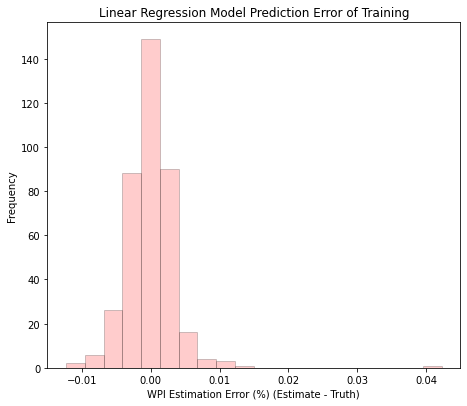

In [41]:
# Step 3: - Make predictions using the testing dataset
y_train = linear_reg.predict(X)
print('Variance explained: %.2f' % r2_score(df_train['WPI'].values, y_train))

y_res_train = y_train - df_train['WPI'].values
print('Training: Residual: mean = ' + str(round(np.average(y_res_train),2)) + ', standard deviation = ' + str(round(np.std(y_res_train),2)))

plt.subplot(122)
plt.hist(y_res_train, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error of Training'); plt.xlabel('WPI Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Variance explained: 1.00
Testing: Residual: mean = 0.0, standard deviation = 0.0


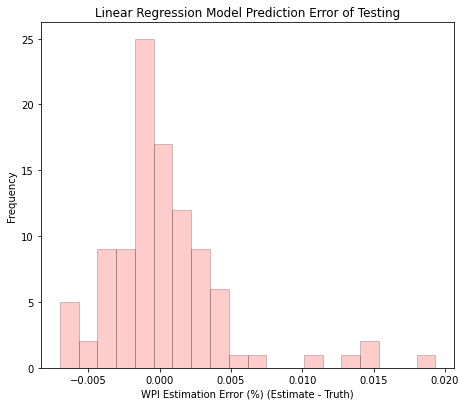

In [42]:
# Step 3: - Make predictions using the testing dataset
x_test = df_test[["Phosphate","Ca","TDS","EC","Cl","DO","Mg","Na","F","pH"]]
y_pred = linear_reg.predict(x_test)
print('Variance explained: %.2f' % r2_score(df_test['WPI'].values, y_pred))

y_res_lin = y_pred - df_test['WPI'].values
print('Testing: Residual: mean = ' + str(round(np.average(y_res_lin),2)) + ', standard deviation = ' + str(round(np.std(y_res_lin),2)))

plt.subplot(122)
plt.hist(y_res_lin, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error of Testing'); plt.xlabel('WPI Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

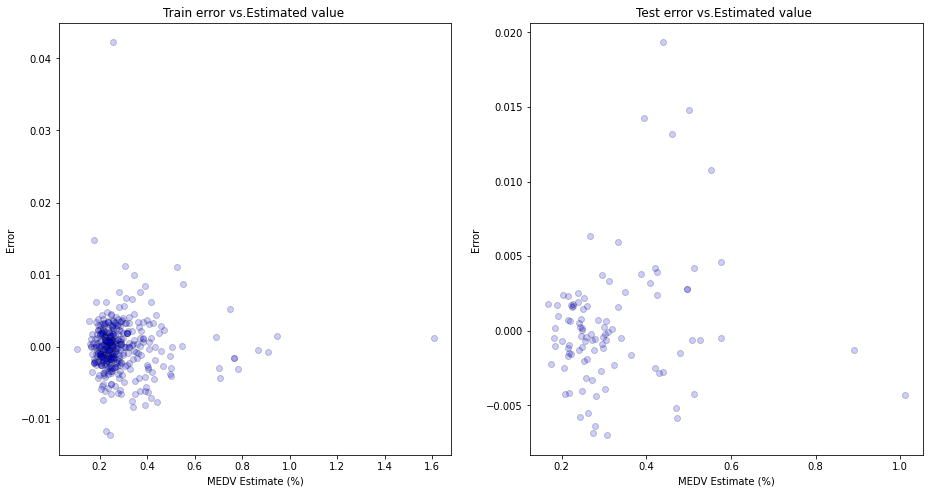

In [43]:
plt.subplot(121)
plt.plot( y_train,y_res_train, 'o', color = 'blue', alpha = 0.2, markeredgecolor = 'black')
plt.title('Train error vs.Estimated value ')
plt.xlabel('MEDV Estimate (%)')
plt.ylabel('Error ')

plt.subplot(122)
plt.plot( y_pred,y_res_lin, 'o', color = 'blue', alpha = 0.2, markeredgecolor = 'black')
plt.title('Test error vs.Estimated value ')
plt.xlabel('MEDV Estimate (%)')
plt.ylabel('Error ')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

In [44]:
lam =5857
x_train = df_train[["Phosphate","Ca","TDS","EC","Cl","DO","Mg","Na","F","pH"]]
x_test = df_test[["Phosphate","Ca","TDS","EC","Cl","DO","Mg","Na","F","pH"]]
# Step 1. Instantiate the Model 
ridge_reg = Ridge(alpha=lam)
# Step 2: Fit the Data on Training Data
ridge_reg.fit(x_train, df_train["WPI"]) # fit model
# Print the model parameters
print('Coefficients of Phosphate: ', str(round(ridge_reg.coef_[0],3)) + '\n' + 'Coefficients of Ca: ', str(round(ridge_reg.coef_[1],3)) + '\n'  + 'Coefficients of TDS: ', str(round(ridge_reg.coef_[2],3)) + '\n' + 'Coefficients of Cl: ', str(round(ridge_reg.coef_[3],3)) + '\n'  + 'Coefficients of DO: ', str(round(ridge_reg.coef_[4],3)) + '\n' + 'Coefficients of Mg: ', str(round(ridge_reg.coef_[5],3)) + '\n'+ 'Coefficients of Na: ', str(round(ridge_reg.coef_[6],3)) + '\n'+ 'Coefficients of F: ', str(round(ridge_reg.coef_[7],3)) + '\n'+ 'Coefficients of pH: ', str(round(ridge_reg.coef_[8],3)) + '\n' +'Intercept: ', str(round(linear_reg.intercept_,3)))

Coefficients of Phosphate:  0.001
Coefficients of Ca:  -0.0
Coefficients of TDS:  0.001
Coefficients of Cl:  0.0
Coefficients of DO:  -0.0
Coefficients of Mg:  0.0
Coefficients of Na:  -0.001
Coefficients of F:  0.0
Coefficients of pH:  0.001
Intercept:  -0.22


Variance explained: 0.34
Ridge: Residual: mean = -0.0, standard deviation = 0.11


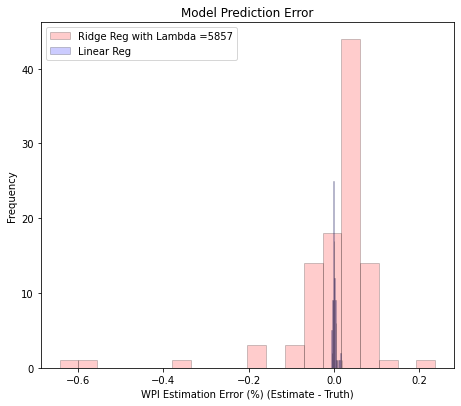

In [45]:
# Step 3: - Make predictions using the testing dataset

y_pred = ridge_reg.predict(x_test)
# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(df_test['WPI'].values, y_pred))

# Plot testing diagnostics 
plt.xlim(1.0,2.6); plt.ylim(5,24)

y_res = y_pred - df_test['WPI'].values
print('Ridge: Residual: mean = ' + str(round(np.average(y_res),2)) + ', standard deviation = ' + str(round(np.std(y_res),2)))

plt.subplot(121)
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, label='Ridge Reg with Lambda ='+str(int(lam)))
plt.hist(y_res_lin, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, label='Linear Reg')
plt.title('Model Prediction Error');
plt.xlabel('WPI Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

In [46]:
# Arrays to store the results
ncases = 100
lamd_mat = np.logspace(np.log10(1e-5),np.log10(1e9),ncases)
var_explained_train = np.zeros(ncases); var_explained_test = np.zeros(ncases)
mse_train = np.zeros(ncases); mse_test = np.zeros(ncases)

In [50]:
# Loop over all lambda values
for ilam in range(0,len(lamd_mat)): 
    ridge_reg = Ridge(alpha=lamd_mat[ilam])
    ridge_reg.fit(x_train, df_train["WPI"]) # fit model

    wpi_pred_train = ridge_reg.predict(x_train) # predict with the fit model   
    var_explained_train[ilam] = r2_score(df_train['WPI'].values, wpi_pred_train)
    mse_train[ilam] = mean_squared_error(df_train['WPI'].values, wpi_pred_train) 
    
    wpi_pred_test = ridge_reg.predict(x_test )
    var_explained_test[ilam] = r2_score(df_test['WPI'].values, wpi_pred_test)
    mse_test[ilam] = mean_squared_error(df_test['WPI'].values, wpi_pred_test)    

imin=np.argmin(mse_test)   
tuned_lamda = int(lamd_mat[imin])                         # get the hyperparameter value with the minimum testing error
print('Minimum MSE with hyperparameter lamd = %.0f' % tuned_lamda)

(m,i) = min((v,i) for i,v in enumerate(mse_test))
print (m,i)
print(lamd_mat[i])

Minimum MSE with hyperparameter lamd = 0
1.8350846332372733e-05 0
1e-05


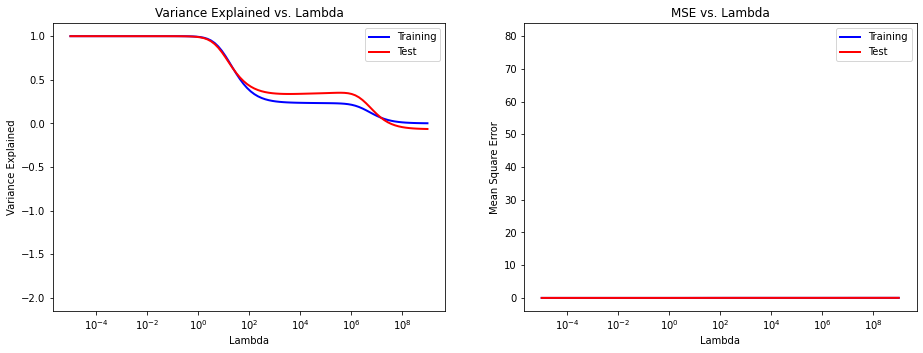

In [51]:
plt.subplot(121)
plt.plot(lamd_mat, var_explained_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, var_explained_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[-2,1],color='black') # 
plt.title('Variance Explained vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Variance Explained')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

plt.subplot(122)
plt.plot(lamd_mat, mse_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, mse_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[0,80],color='black') # vertical line at hyperparameter value that minimizes testing error 
plt.title('MSE vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Mean Square Error')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

In [53]:
lam_lasso = 2

# Step 1. Instantiate the Model 
lasso_reg = Lasso(alpha=lam_lasso)

# Step 2: Fit the Data on Training Data
lasso_reg.fit(x_train, df_train["WPI"]) # fit model
print('Coefficients of Phosphate: ', str(round(lasso_reg.coef_[0],3)) + '\n' + 'Coefficients of Ca: ', str(round(lasso_reg.coef_[1],3)) + '\n'  + 'Coefficients of TDS: ', str(round(lasso_reg.coef_[2],3)) + '\n' + 'Coefficients of Cl: ', str(round(lasso_reg.coef_[3],3)) + '\n'  + 'Coefficients of DO: ', str(round(lasso_reg.coef_[4],3)) + '\n' + 'Coefficients of Mg: ', str(round(lasso_reg.coef_[5],3)) + '\n'+ 'Coefficients of Na: ', str(round(lasso_reg.coef_[6],3)) + '\n'+ 'Coefficients of F: ', str(round(lasso_reg.coef_[7],3)) + '\n'+ 'Coefficients of pH: ', str(round(lasso_reg.coef_[8],3)) + '\n' +'Intercept: ', str(round(lasso_reg.intercept_,3)))

Coefficients of Phosphate:  0.0
Coefficients of Ca:  0.0
Coefficients of TDS:  0.0
Coefficients of Cl:  0.0
Coefficients of DO:  0.0
Coefficients of Mg:  -0.0
Coefficients of Na:  0.0
Coefficients of F:  0.0
Coefficients of pH:  0.0
Intercept:  0.195


Variance explained: 0.29
Residual: mean = -0.02, standard deviation = 0.01


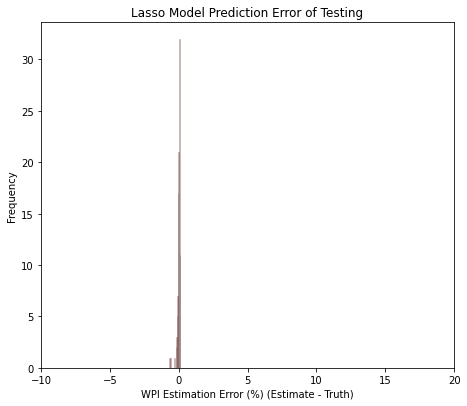

In [57]:
# Step 3: - Make predictions using the testing dataset
y_pred_test_las = lasso_reg.predict(x_test)

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(df_test['WPI'].values, y_pred_test_las))

y_res_test_las = y_pred_test_las - df_test['WPI'].values
print('Residual: mean = ' + str(round(np.average(y_res_test_las),2)) + ', standard deviation = ' + str(round(np.var(y_res_test_las),2)))

plt.subplot(122)
plt.hist(y_res_test_las, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Lasso Model Prediction Error of Testing'); plt.xlabel('WPI Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.xlim(-10,20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

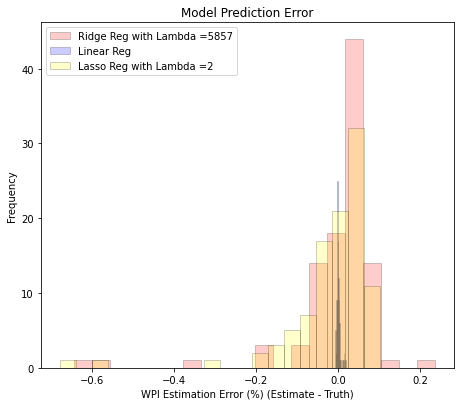

In [58]:
plt.subplot(121)
#test
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, label='Ridge Reg with Lambda ='+str(int(lam)))
plt.hist(y_res_lin, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, label='Linear Reg')
plt.hist(y_res_test_las, alpha = 0.2, color = 'yellow', edgecolor = 'black', bins=20, label='Lasso Reg with Lambda ='+str(int(lam_lasso)))
plt.title('Model Prediction Error');
plt.xlabel('WPI Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

In [59]:
# Arrays to store the results
ncases = 100
lamd_mat = np.logspace(np.log10(1e-5),np.log10(1e5),ncases)
var_explained_train = np.zeros(ncases); var_explained_test = np.zeros(ncases)
mse_train = np.zeros(ncases); mse_test = np.zeros(ncases)

In [60]:
# Loop over all lambda values
for ilam in range(0,len(lamd_mat)): 
    lasso_reg = Lasso(alpha=lamd_mat[ilam])
    lasso_reg.fit(x_train, df_train["WPI"]) # fit model

    MEDV_pred_train = lasso_reg.predict(x_train) # predict with the fit model   
    var_explained_train[ilam] = r2_score(df_train['WPI'].values, MEDV_pred_train)
    mse_train[ilam] = mean_squared_error(df_train['WPI'].values, MEDV_pred_train) 
    
    MEDV_pred_test = lasso_reg.predict(x_test )
    var_explained_test[ilam] = r2_score(df_test['WPI'].values, MEDV_pred_test)
    mse_test[ilam] = mean_squared_error(df_test['WPI'].values, MEDV_pred_test)    

imin=np.argmin(mse_test)   
tuned_lamda = int(lamd_mat[imin])                         # get the hyperparameter value with the minimum testing error
print('Minimum MSE with hyperparameter lamd = %.0f' % tuned_lamda)

(m,i) = min((v,i) for i,v in enumerate(mse_test))
print (m,i)
print(lamd_mat[i])

Minimum MSE with hyperparameter lamd = 0
1.835088568388439e-05 0
1e-05


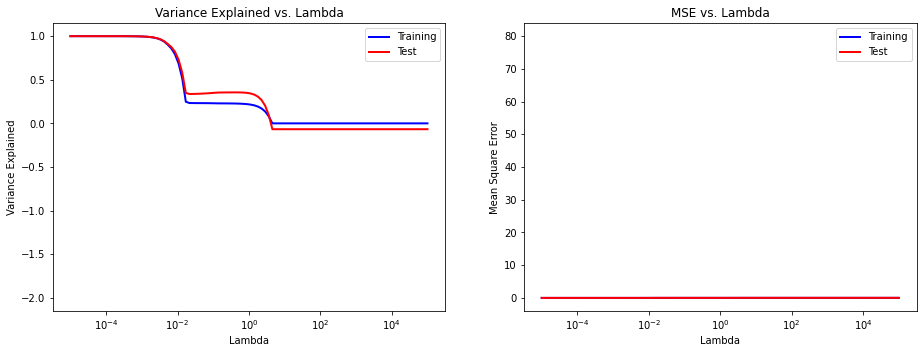

In [61]:
plt.subplot(121)
plt.plot(lamd_mat, var_explained_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, var_explained_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[-2,1],color='black') # 
plt.title('Variance Explained vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Variance Explained')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

plt.subplot(122)
plt.plot(lamd_mat, mse_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, mse_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[0,80],color='black') # vertical line at hyperparameter value that minimizes testing error 
plt.title('MSE vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Mean Square Error')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()